# Introduction
This notebook explores AUTO mpg dataset. 


The objective of this data science project is to predict **miles per gallon (mpg)** for a given car. 

Before seeing the data let us answer 3 questions:

1. Is it a supervised, unsupervised, or Reinforcement Learning?
        This is a supervised learning. We know that we have to predict miles per gallon (mpg).
2. Is it a classification task, a regression task, or something else?
        We have to predict Miles per gallon. mpg is a measure of fuel economy of a car and it is a numerical value. Hence this is a regression task.
3. Should we use batch learning or online learning techniques?
        As there is no continuous flow of data coming into the system, so batch learning is enough.


Let us begin with importing necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='svg'

# 1. Getting the data

In [2]:
df = pd.read_csv('../input/auto-mpg.csv')

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
df.shape

(398, 9)

Dataset has 398 observations and 9 feature columns.
Independent variables are :
1. car name
2. cylinders
3. displacement
4. horsepower
5. weight
6. acceleration
7. model year
8. origin

Dependent variable is:
9. mpg

Let us check the data type of the columns.

In [5]:
def check_data_types(data):
    data_types = data.dtypes.reset_index()
    data_types.columns = ['columnn_name','data_type']
    return data_types 

In [6]:
check_data_types(df)

,columnn_name,data_type
0,mpg,float64
1,cylinders,int64
2,displacement,float64
3,horsepower,object
4,weight,int64
5,acceleration,float64
6,model year,int64
7,origin,int64
8,car name,object


We have 7 numeric(3 continuous and 4 discrete) and 2 object columns. Don't you think that 'horsepower' should be a numeric value and not an object? Then, let us change the datatype of horsepower from object to numeric.

df['horsepower'] = df['horsepower'].astype('float64')

This line of code throws as error saying "could not convert string to float: '?'". What does this mean?
This means that this column has an entry with value '?' and this cannot be converted to float. Let us check how many rows have '?' in 'horsepower' columns.

In [7]:
df.loc[df.horsepower=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


There are 6 rows with '?' in the column 'horsepower'. Let us get rid of these rows.

In [8]:
df = df.loc[df.horsepower!='?']

Now, lets try changing the datatype of horsepower from object to float64

In [9]:
df['horsepower'] = df['horsepower'].astype('float64')

In [10]:
check_data_types(df)

,columnn_name,data_type
0,mpg,float64
1,cylinders,int64
2,displacement,float64
3,horsepower,float64
4,weight,int64
5,acceleration,float64
6,model year,int64
7,origin,int64
8,car name,object


Cool!! Thats done. But are there missing values in other columns? Let us check. But before that let us save our features in different lists based on their data types.

In [11]:
numerical_cont = ['displacement', 'horsepower', 'weight', 'acceleration','mpg']
numerical_discrete = ['cylinders','model_year', 'origin']
categorical = ['car_name']

Checking missing values. No missing values are present in the data.

In [12]:
df.isnull().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name        False
dtype: bool

# 2. Exploring the data

Let us study the correlation between the columns.

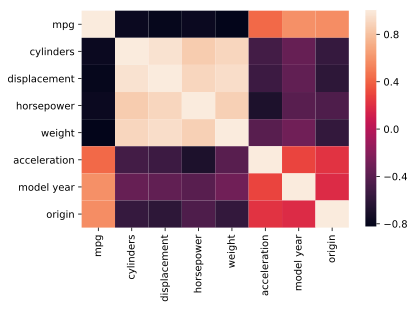

In [13]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)

From the above heatmap, we can observe that cylinders, displacement, horsepower and weight are strongly and negatively correlated with mpg. acceleration, model_year and origin are weakly and positively correlated with mpg.

Let us plot scatter_matrix to view the relationship between the numerical predictors.

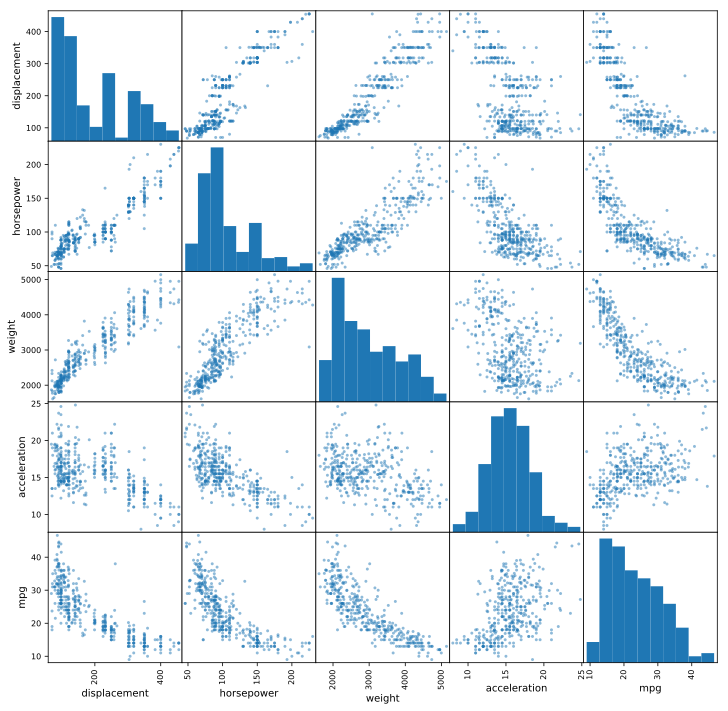

In [14]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[numerical_cont],figsize=(12,12))
plt.show()

From the last row of above plot, we can observe the relationship between mpg and other predictors displacement, horsepower, weight, acceleration. As observed from the correlation matrix, displacement, horsepower and weight are negatively correlated with mpg. acceleration doesn't show strong correlation with acceleration.

Now, let us explore relationship between our dependent variable 'mpg' and numeric_discrete predictors.

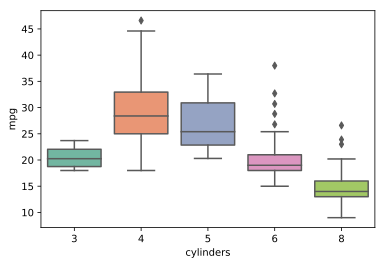

In [15]:
sns.boxplot(x = 'cylinders', y = 'mpg', data = df, palette = "Set2")

Mpg of cars having Cylinder 4 is the highest. 

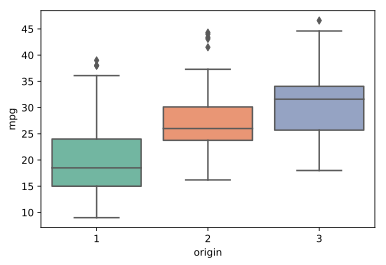

In [16]:
sns.boxplot(x = 'origin', y = 'mpg', data = df, palette = "Set2")

Origin column is basically the origin where car was manufactured. On average cars from origin 3 have higher mpg.

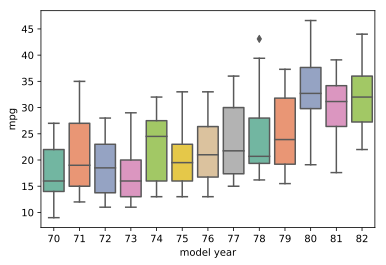

In [17]:
sns.boxplot(x = 'model year', y = 'mpg', data = df, palette = "Set2")

median mpg of cars seem to be increasing with each year.

# 3. Building a pipeline for further data processing

There are 2 different pipelines for processing numerical data and categorical data:
1. num_pipeline has 2 transformers. Imputer for handling missing values and standard scalar for scaling the features. 
2. cat_pipeline has 2 transformers. Imputer for handling the missing values and OneHotEncoder for encoding categorical variables.

Note : I am going to drop 'car name' column from the analysis.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_attribs = ['displacement', 'horsepower', 'weight', 'acceleration']
cat_attribs = ['cylinders','model year', 'origin']


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('one_hot_encoder',OneHotEncoder(handle_unknown='ignore',sparse=False)),
])

ColumnTransformer applies each transformer to the appropriate columns and concatenates the outputs along the second axis.

In [19]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Applying the pipeline to our dataset.

In [20]:
df_x = df.drop(columns=['mpg'])
df_y = df['mpg']
df_MPG = full_pipeline.fit_transform(df_x, df_y)

Let us view the transformed dataset.

In [21]:
pd.DataFrame(df_MPG).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,1.077290,0.664133,0.620540,-1.285258,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.488732,1.574594,0.843334,-1.466724,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.182542,1.184397,0.540382,-1.648189,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.048584,1.184397,0.536845,-1.285258,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.029447,0.924265,0.555706,-1.829655,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 4. Create Train Test Split

Let us create train and test set

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_MPG, df_y, test_size = 0.2, random_state = 42)

# 5. Fitting regression model 

a. Lets create a baseline with Naive model. Let us assume that the estimate of mpg for test data is equal to the average of mpg values in test data.

In [23]:
from sklearn.metrics import mean_squared_error
mpg_mean = np.mean(y_train)
y_pred = np.full(len(X_test),mpg_mean)

print('test loss is....')
print(np.sqrt(mean_squared_error(y_pred,y_test)))

test loss is....
7.184726327203214


b. Now let us fit linear regression model and see if it does any better than naive model.

In [24]:
from sklearn.linear_model import LinearRegression


regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('test loss is:')
print(np.sqrt(mean_squared_error(y_pred,y_test)))

y_pred = regressor.predict(X_train)
print('train loss is:')
print(np.sqrt(mean_squared_error(y_pred,y_train)))

test loss is:
2.5849031064993047
train loss is:
2.8241040720712673


Linear regression model certainly does better than our naive model. We can fit other regressors like RandomForest, XGBoost etc, but let me save that for my next task.

This is my first data science project and I learnt a great deal executing it. Please leave a comment if you have any feedback. I look forward to learning from you. Thank you!